
# Setup

In [1]:
# for computing
import numpy as np
import xarray as xr # for reading/writing netcdf
import dask.array as da
import dask
import pandas as pd # only used for date times

# convenience things
from time import time, sleep
import os
import glob # for system commands
from natsort import natsorted # for alphabetical sorting

# for plotting
import matplotlib.pyplot as plt

In [2]:
# contain worker logs in their own folder
homedir = os.environ['HOME']
daskpath=os.path.join(homedir, "dask-worker-space-can-be-deleted")

try: 
    os.mkdir(daskpath) 
except OSError as error: 
    print(error) 

[Errno 17] File exists: '/home/kerrie/dask-worker-space-can-be-deleted'


In [3]:
# your notebook directory location, change per user
repo_dir='/work/hpc/users/kerrie/UN_FAO/repos/py_AEZ_data_prep/'

# link to where this notebook lives on github, same for everyone
nb_link='https://github.com/kerriegeil/pyAEZ_data_prep/blob/main/global/01_dat_to_nc.ipynb'

# data directory location, same for everyoe
data_dir='/work/hpc/datasets/un_fao/'

# your output directory location, change per user
# to not overwrite data files you need to change these to a location 
# under your /work/hpc/users/username directory
# and make sure the directories exist before running the script (mkdir)
out_dir_static=data_dir+'gaez/static/'
out_dir_time=data_dir+'gaez/global_1980/dailydev/netcdf/'

# the ALOSmask file that has matching grid to your pxv/dat data, same for everyone
maskfile=data_dir+'pyaez/static/rst/ALOSmask5m_fill.rst'

# source info to include in file metadata, same for everyone
source_dirs=['on MSU HPC2 /gri/projects/UN_FAO/',
             'on Orion /work/hpc/datasets/un_fao/gaez/global_1980/dailydev/dat/']

# all this is same for everyone
# file/variable info
year=1980
fillval=-9999. # value used for missing in the dat files
varnames=['Precip','Srad','Tmax-2m','Tmin-2m','Vapr','Wind-10m'] # save varnames for later

# scale and units info from the file "UnitScaleFactors.txt" from Gunther
scale_factor=[1E-5,1000.,0.01,0.01,0.01,0.001]
units=['unitless (mm/mm)','J/m2/day','degrees C','degrees C','hPa','m/s']
long_names=['precipitation fraction','surface short wave radiation','2m maximum air temperature','2m minimum air temperature','vapor pressure','10m wind speed']

# metadata for output data files
timeattrs={'standard_name':'time','long_name':'time','axis':'T'}
latattrs={'standard_name':'latitude','long_name':'latitude','units':'degrees_north','axis':'Y'}
lonattrs={'standard_name':'longitude','long_name':'longitude','units':'degrees_east','axis':'X'}

# encoding info for writing netcdf files
time_encoding={'calendar':'standard','units':'days since 1900-01-01 00:00:00','_FillValue':None}
lat_encoding={'_FillValue':None}
lon_encoding={'_FillValue':None}
var_encoding = {'zlib':True,'dtype':'float32'}

# Read data from dat file

In [4]:
# list of dat files to convert
filelist=natsorted(glob.glob(data_dir+'gaez/global_'+str(year)+'/dailydev/dat/*'+str(year)+'*'))
filelist

['/work/hpc/datasets/un_fao/gaez/global_1980/dailydev/dat/Precip365_AgERA5_Hist_1980_5m.dat',
 '/work/hpc/datasets/un_fao/gaez/global_1980/dailydev/dat/Srad365_AgERA5_Hist_1980_5m.dat',
 '/work/hpc/datasets/un_fao/gaez/global_1980/dailydev/dat/Tmax-2m365_AgERA5_Hist_1980_5m.dat',
 '/work/hpc/datasets/un_fao/gaez/global_1980/dailydev/dat/Tmin-2m365_AgERA5_Hist_1980_5m.dat',
 '/work/hpc/datasets/un_fao/gaez/global_1980/dailydev/dat/Vapr365_AgERA5_Hist_1980_5m.dat',
 '/work/hpc/datasets/un_fao/gaez/global_1980/dailydev/dat/Wind-10m365_AgERA5_Hist_1980_5m.dat']

NOTE: RUN PRECIP v=0 FIRST BECAUSE YOU NEED THE DATA MASK FROM THIS VARIABLE FOR THE OTHER VARIABLES. To process additional variables after precipiation start here and change v

In [5]:
# which var to process, v=0 processes Precip
v=0

print('Processing variable =',varnames[v])

Processing variable = Precip


In [6]:
# get each line from dat file as a string and remove carriage returns
temp=open(filelist[v]).read().splitlines() 

# grab the lines with lat/lons (every other line)
ilatilon=temp[0::2] 

# grab the lines with the data (every other line)
data=temp[1::2]

In [7]:
# get each string lat/lon as integer and put it in an numpy array
ilat=np.array([int(i.split()[0]) for i in ilatilon]).astype('int16') 
ilon=np.array([int(i.split()[1]) for i in ilatilon]).astype('int16') 

# put data in a numpy array too, takes 30-60s
data2D=np.loadtxt(data,dtype='int16')
nt=data2D.shape[1]

print('data dimensions:', data2D.shape[0],'rows (each row represents a different grid cell) by',nt,'cols (each col represents a day of the year)')

print('data min max:',data2D.min(),data2D.max())

data dimensions: 2295358 rows (each row represents a different grid cell) by 366 cols (each col represents a day of the year)
data min max: -9999 10000


In [8]:
# per Gunther, the number of grids in each pxv file with data present should be 2287408
# some files have more, some files have less
# we will fix this by applying a mask later

# how many precip grids have data?  
nomissing=np.where(data2D==-9999,0,1)
nomissing.sum()/nt

2287408.0

# Get grid info from mask file

In [9]:
# get the lats and lons from the ALOSmask5m_fill.rst file
mask=xr.open_dataset(maskfile,engine='rasterio').squeeze()['band_data'] 
mask=mask.drop('band')

mask

<xarray.DataArray 'band_data' (y: 2160, x: 4320)>
[9331200 values with dtype=float32]
Coordinates:
  * x            (x) float64 -180.0 -179.9 -179.8 -179.7 ... 179.8 179.9 180.0
  * y            (y) float64 89.96 89.88 89.79 89.71 ... -89.79 -89.87 -89.96
    spatial_ref  int64 ...
Attributes:
    units:    unspecified

In [10]:
# how many non-zero grids in the ALOS mask file?
# more than the 2287408 number
test=xr.where(mask>0,1,0)
test=xr.where(mask.y<-60,0,test) # eliminate Antarctica
test.data.sum()

2295358

In [11]:
# save coordinate information for creating netcdf files
nlats,nlons=mask.shape
lats=mask.y.data.astype('float32')
lons=mask.x.data.astype('float32')

# create a time dimension
time=pd.date_range(str(year)+'-01-01',str(year)+'-12-31',freq='D')

# if leap day is deleted out of the dataset, fix up time to match
if len(time) != nt:
    time=time[~(time==str(year)+'-02-29')]

print('global data dimensions:',nlats,'latitudes by',nlons,'longitudes by',nt,'days')

global data dimensions: 2160 latitudes by 4320 longitudes by 366 days


we now have the metadata needed (lat, lon, time info) to create an xarray data array to store global data

# Start a compute cluster with dask distributed 

if you started jupyter notebook session with many nodes/cores, use LocalCluster below and cluster.scale(number) appropriately for how many nodes/cores you have running. THIS METHOD IS RECOMMENDED DUE TO HIGH USAGE ON ORION WHICH CAN LEAVE SLURMCLUSTER WORKERS IN THE QUEUE

If you started this jupyter notebook session on 1 node with few cores, shut down this session and open a new session on 6 nodes, 120 cores (6 nodes * 20 cores per node) and also use the --exclusive flag under additional slurm parameters. Then re-open this notebook to run it.

Notes

- setting the cluster to 1 worker = a full node of cores (20), then scaling up is the way to go

- the default settings with less cores/threads per worker and more workers takes much longer to compute

- for LocalCluster: don't start/scale the cluster more than once. If you need to start a new one, restart the whole kernel first and re-run the notebook

In [12]:
# DON'T RUN THIS CELL MORE THAN ONCE, SKIP WHEN PROCESSING ADDITIONAL VARIABLES
# don't run this cell more than once unless you restart the jupyter kernel first and then rerun the notebook up to this point

# for LocalCluster
from dask.distributed import Client,LocalCluster
cluster=LocalCluster(n_workers=1,threads_per_worker=20) # define your compute cluster (does not start any computing)

############################################################
# ADJUST THIS NUMBER
############################################################
# the following assumes you opened your jupyter session on multiple full nodes e.g. x nodes and x*20 cores
nodes=6 # adjust this to however many nodes you opened your session with
############################################################

# start and scale up your local computing cluster
client=Client(cluster)  # connect to your compute cluster
cluster.scale(nodes-1)  # scale up your compute cluster to more nodes
sleep(2)
client # click on "Cluster Info" below to see how many workers and threads are running in the local cluster

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 4
Total threads: 80,Total memory: 720.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:35268,Workers: 3
Dashboard: http://127.0.0.1:8787/status,Total threads: 60
Started: Just now,Total memory: 540.00 GiB
Comm: tcp://127.0.0.1:38618,Total threads: 20
Dashboard: http://127.0.0.1:38690/status,Memory: 180.00 GiB
Nanny: tcp://127.0.0.1:35816,


In [13]:
# if workers didn't show up above run this cell. workers should show up under "Local Cluster" below
sleep(10)
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 5
Total threads: 100,Total memory: 900.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:35268,Workers: 5
Dashboard: http://127.0.0.1:8787/status,Total threads: 100
Started: Just now,Total memory: 900.00 GiB
Comm: tcp://127.0.0.1:38618,Total threads: 20
Dashboard: http://127.0.0.1:38690/status,Memory: 180.00 GiB
Nanny: tcp://127.0.0.1:35816,


# Use dask delayed parallel computing to put data onto global grid

loop thru each latitude to create a chunk of the global data array, where grid cells without data are filled with nan

inside the loop we issue calls to functions that do the heavier computing tasks

we delay those functions to create a dask task graph on length ny=2160 and then set off all the tasks to compute

In [14]:
# function to build a chunk of data for grids where data is present

@dask.delayed
def build_full_lat(ixs,data,y,x,t,fv,sf):
    # create nan array of shape (all days, 1 lat, all lons)
    arr=xr.DataArray(np.nan,
                     dims=['time','lat','lon'],
                     coords={'time':('time',time),'lat':('lat',y),'lon':('lon',x)}).astype('float32')
    
    for i,ix in enumerate(ixs):
        arr[:,0,ix]=data[i,:]
    
    # below only works when the fill value is not in the range of data
    # only do this for precip so we can save the mask
    # for everything else, instead of converting -9999 to nan here,
    # scale everything including the fill value and apply the mask at the end
    if v==0:                    # if variable is precip
        arr=arr.where(arr!=fv)  # assign replace all -9999 with nan

    arr=arr*sf # apply scale factor
    
    return arr

In [15]:
# function to build a chunk of data for grids where data is not present

@dask.delayed
def build_empty_lat(y,x,t):
    # create nan array of shape (all days, 1 lat, all lons)    
    arr=xr.DataArray(np.nan,
                     dims=['time','lat','lon'],
                     coords={'time':('time',time),'lat':('lat',y),'lon':('lon',x)}).astype('float32')
    return arr

now we write a normal not-delayed loop to call the delayed functions and collect all the delayed tasks into a list called tasklist

In [16]:
tasklist=[] # empty list for storing delayed computing tasks

# parellilze by latitude (latitude loop)
for iy in range(nlats):
    
    indices=np.where(ilat==iy+1)[0] # find which data rows apply to this latitude
    
    # if there is any data present at this latitude call build_full_lat function
    if np.any(indices):
        result=build_full_lat((ilon[indices]-1),data2D[indices,:],lats[iy:iy+1],lons,time,fillval,scale_factor[v]) # lazy call to func returns a task
        tasklist.append(result) # collect list of compute tasks
    # if there is no data present at this latitude call build_empty_lat function
    else:
        result=build_empty_lat(lats[iy:iy+1],lons,time)
        tasklist.append(result)

dask.compute starts the parallel computing and pulls all the results down from workers into a list of arrays

note: the use of *tasklist means output will be a list of len ny=2160 of arrays, without * the output will be len 1

In [17]:
# ignore the warning

# on 5 or 6 nodes expect a few minutes run time, maybe 4-8 min
output=dask.compute(*tasklist) # execute all the delayed compute tasks across our local cluster
output[0] # look at 1 array in the list

/work/hpc/users/kerrie/envs/dataprep/lib/python3.11/site-packages/distributed/worker.py:2995: UserWarning: Large object of size 0.96 MiB detected in task graph: 
  (array([ 728,  729,  730, ..., 3919, 3920, 3921],  ... -9999.0, 1e-05)
Consider scattering large objects ahead of time
with client.scatter to reduce scheduler burden and 
keep data on workers

    future = client.submit(func, big_data)    # bad

    big_future = client.scatter(big_data)     # good
    future = client.submit(func, big_future)  # good
  warnings.warn(


<xarray.DataArray (time: 366, lat: 1, lon: 4320)>
array([[[nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan]],

       ...,

       [[nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan]]], dtype=float32)
Coordinates:
  * time     (time) datetime64[ns] 1980-01-01 1980-01-02 ... 1980-12-31
  * lat      (lat) float32 89.96
  * lon      (lon) float32 -180.0 -179.9 -179.8 -179.7 ... 179.8 179.9 180.0

now concat all the arrays into a single large array

In [18]:
bigarr=xr.concat(output,dim='lat')
# bigarr

# create or apply mask

In [19]:
# the ALOS mask provided doesn't match where there is and is not data present in the pxv/dat files
# save a new mask from the precip pxv file
if v==0:
    newmask=xr.where(np.isfinite(bigarr[0,:,:]),1,0) # 2160x4320 mask of 0&1
    # assign metadata
    newmask.name='mask'
    newmask=newmask.drop('time')
    newmask['lat'].attrs=latattrs
    newmask['lon'].attrs=lonattrs
    newmask.attrs={'description':'binary admin mask created using ALOSmask5m_fill.rst and the precip pxv file'}
    newmask=newmask.to_dataset()
    newmask=newmask.assign_coords({'spatial_ref':mask.spatial_ref})
    # write mask netcdf file
    newmask.to_netcdf(out_dir_static+'mask_2287408_5m.nc',
                encoding={'lat':lat_encoding,'lon':lon_encoding,'mask':var_encoding})  
else:
    # if variable is not precip
    # load and apply the new mask
    newmask=xr.open_dataset(out_dir_static+'mask_2287408_5m.nc') # read the mask file
    bigarr=xr.where(newmask==1,bigarr,np.nan) # .where reorders dimensions so we have to fix below
    bigarr=bigarr['mask'].transpose('time','lat','lon') # change dataset back to array with proper ordering    

In [20]:
# variable/coordinate metadata
varattrs={'standard_name':varnames[v],'long_name':long_names[v],'units':units[v]}

# assign metadata
bigarr.name=varnames[v]
bigarr.attrs=varattrs
bigarr['lat'].attrs=latattrs
bigarr['lon'].attrs=lonattrs
bigarr['time'].attrs=timeattrs

# array to dataset
ds=bigarr.to_dataset()
ds=ds.assign_coords({'spatial_ref':mask.spatial_ref})
ds=ds.assign_attrs({'source_data':source_dirs,
                    'source_code':nb_link})

print('bigarr is',bigarr.nbytes*1E-6,'MB')

ds

bigarr is 13660.8768 MB


<xarray.Dataset>
Dimensions:      (time: 366, lat: 2160, lon: 4320)
Coordinates:
  * time         (time) datetime64[ns] 1980-01-01 1980-01-02 ... 1980-12-31
  * lat          (lat) float32 89.96 89.88 89.79 89.71 ... -89.79 -89.88 -89.96
  * lon          (lon) float32 -180.0 -179.9 -179.8 -179.7 ... 179.8 179.9 180.0
    spatial_ref  int64 0
Data variables:
    Precip       (time, lat, lon) float32 nan nan nan nan ... nan nan nan nan
Attributes:
    source_data:  ['on MSU HPC2 /gri/projects/UN_FAO/', 'on Orion /work/hpc/d...
    source_code:  https://github.com/kerriegeil/pyAEZ_data_prep/blob/main/glo...

let's take a look at the data

Text(0.5, 1.0, 'Precip dev 1980-06-01')

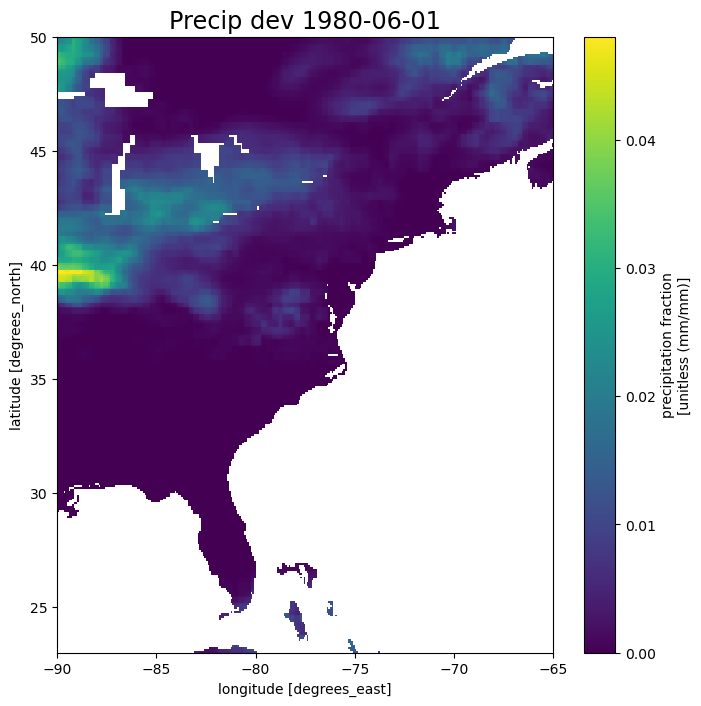

In [21]:
import matplotlib.pyplot as plt

t='1980-06-01'

fig=plt.figure(figsize=(8,8))
ax=fig.add_subplot(111)

bigarr.sel(lat=slice(50,23),lon=slice(-90,-65),time=t).plot(ax=ax)
plt.title(varnames[v]+' dev '+t,fontsize='xx-large')


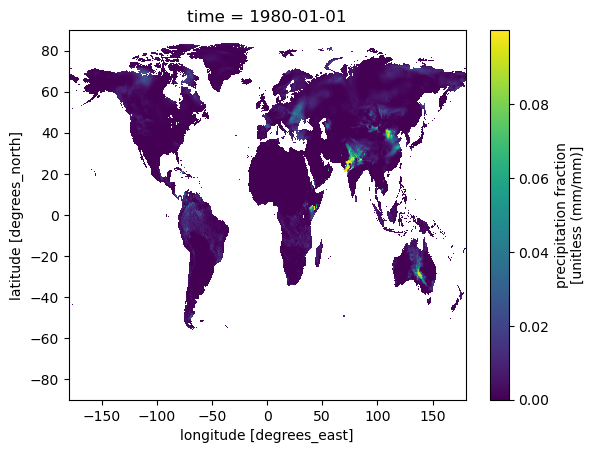

In [22]:
bigarr[0,:,:].plot()

# Write netcdf file with compression



In [23]:
# writing with compression, will take a few minutes
ds.to_netcdf(out_dir_time+varnames[v]+'_DailyDev_'+str(year)+'_5m.nc',
            encoding={'lat':lat_encoding,
                      'lon':lon_encoding,
                      'time':time_encoding,
                      varnames[v]:var_encoding})

#### process all other variables using the appropriate cells above, then proceed to below

# Check netcdf files

double checking that all files have 2287408 grids with data

In [24]:
files=natsorted(glob.glob(out_dir_time+'*_DailyDev_'+str(year)+'_5m.nc'))

In [25]:
for f in files:
    d=xr.open_dataset(f) # read a data file
    vn=list(d.keys())[0]  # get variable name
    d=np.where(np.isfinite(d[vn].isel(time=0)),1,0)  # select one timestep and create mask
    print(vn,'has',d.sum(),'grids with data')  # count how many grids have data

Precip has 2287408 grids with data
Srad has 2287408 grids with data
Tmax-2m has 2287408 grids with data
Tmin-2m has 2287408 grids with data
Vapr has 2287408 grids with data
Wind-10m has 2287408 grids with data
